# Table of Contents:
* [Analysis Without Descriptions](#descriptionless)
    * [Data Cleaning](#cleaning)
    * [Preprocessing](#preprocessing)
    * [Modelling](#modelling)
        * [Logistic Regression](#logregmodel)
        * [Decision Tree](#dtmodel)
        * [Random Forest](#rfmodel)
        * [Support Vector Machine](#svmmodel)
        * [Neural Network](#nnmodel)
* [Analysis With Descriptions](#descriptions)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow import keras
from keras import layers

# Analysis Without Descriptions <a class="anchor" id="descriptionless"></a>

# Data Cleaning <a class="anchor" id="cleaning"></a>

The first step is to get rid of nulls, unnecessary columns, and duplicates, and to change each column to the appropriate data type.

In [2]:
# loading in the non-text data for companies
companies = pd.read_csv('Data/companies.csv',sep=';')

In [3]:
# surveying
companies.head()

,Name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,permalink
0,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,05/01/2015,05/01/2015,/organization/-fame
1,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,04/09/2014,01/03/2014,14/10/2014,/organization/-qounter
2,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,30/01/2014,30/01/2014,/organization/-the-one-of-them-inc-
3,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,01/01/2007,19/03/2008,19/03/2008,/organization/0-6-com
4,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,01/01/2010,24/07/2014,24/07/2014,/organization/004-technologies


In [4]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63215 entries, 0 to 63214
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               63214 non-null  object
 1   homepage_url       59069 non-null  object
 2   category_list      63215 non-null  object
 3   funding_total_usd  63215 non-null  object
 4   status             63215 non-null  object
 5   country_code       57799 non-null  object
 6   state_code         56263 non-null  object
 7   region             56760 non-null  object
 8   city               56762 non-null  object
 9   funding_rounds     63215 non-null  int64 
 10  founded_at         49707 non-null  object
 11  first_funding_at   63192 non-null  object
 12  last_funding_at    63215 non-null  object
 13  permalink          63215 non-null  object
dtypes: int64(1), object(13)
memory usage: 6.8+ MB


In [5]:
companies.isna().sum()

Name                     1
homepage_url          4146
category_list            0
funding_total_usd        0
status                   0
country_code          5416
state_code            6952
region                6455
city                  6453
funding_rounds           0
founded_at           13508
first_funding_at        23
last_funding_at          0
permalink                0
dtype: int64

In [6]:
# drop the one row with a missing name
companies.dropna(subset='Name', inplace=True)

In [7]:
# dropping unnecessary columns
companies.drop(columns=['homepage_url', 'state_code', 'region', 'permalink'], inplace=True)

In [8]:
# dropping the rows where any of the location columns are null
companies.dropna(subset=['country_code', 'city'], inplace=True)

In [9]:
companies.head()

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media,10000000,operating,IND,Mumbai,1,NaN,05/01/2015,05/01/2015
1,:Qounter,Application Platforms|Real Time|Social Network...,700000,operating,USA,Delaware City,2,04/09/2014,01/03/2014,14/10/2014
3,0-6.com,Curated Web,2000000,operating,CHN,Beijing,1,01/01/2007,19/03/2008,19/03/2008
4,004 Technologies,Software,-,operating,USA,Champaign,1,01/01/2010,24/07/2014,24/07/2014
5,01Games Technology,Games,41250,operating,HKG,Hong Kong,1,NaN,01/07/2014,01/07/2014


In [10]:
# resetting the index 
companies.reset_index(drop=True, inplace=True)

In [11]:
companies.isna().sum()

Name                     0
category_list            0
funding_total_usd        0
status                   0
country_code             0
city                     0
funding_rounds           0
founded_at           10856
first_funding_at        22
last_funding_at          0
dtype: int64

##### Now the only null values left are with the 'founded_at' and 'first_funding_at' columns. I want to impute missing values for 'founded_at' from 'first_funding_at', and for 'first_funding_at' from 'last_funding_at'. Before doing that I will need to convert these date columns to datetime types since they are currently object types.

##### *Some of the code below is commented out because it returned errors and I wanted to be able to run all cells in the notebook automatically, but I left it there for reference.

In [12]:
#companies['founded_at'] = pd.to_datetime(companies['founded_at'])

In [13]:
# trying again, but with the format argument set to 'mixed'
#companies['founded_at'] = pd.to_datetime(companies['founded_at'], format='mixed')

In [14]:
# the error says there is a timestamp out of bounds, which company is this?
companies[companies['founded_at'] == '1636-09-08']

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
21347,Harvard University,Colleges|Education|Universities,90000000,operating,USA,Cambridge,1,1636-09-08,06/01/2014,06/01/2014


In [15]:
# remove this row (since Harvard isn't exactly a startup anyway), and then retry converting to datetime
companies.drop(companies[companies['founded_at'] == '1636-09-08'].index, inplace=True)

In [16]:
companies.reset_index(drop=True, inplace=True)

In [17]:
companies[companies['founded_at'] == '1636-09-08'] #it's gone

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at


In [18]:
# trying to convert to datetime again
companies['founded_at'] = pd.to_datetime(companies['founded_at'], format='mixed')

In [19]:
companies.info() # the type is changed now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56760 entries, 0 to 56759
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               56760 non-null  object        
 1   category_list      56760 non-null  object        
 2   funding_total_usd  56760 non-null  object        
 3   status             56760 non-null  object        
 4   country_code       56760 non-null  object        
 5   city               56760 non-null  object        
 6   funding_rounds     56760 non-null  int64         
 7   founded_at         45904 non-null  datetime64[ns]
 8   first_funding_at   56738 non-null  object        
 9   last_funding_at    56760 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 4.3+ MB


In [20]:
companies.head() # nan changed to NaT

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media,10000000,operating,IND,Mumbai,1,NaT,05/01/2015,05/01/2015
1,:Qounter,Application Platforms|Real Time|Social Network...,700000,operating,USA,Delaware City,2,2014-04-09,01/03/2014,14/10/2014
2,0-6.com,Curated Web,2000000,operating,CHN,Beijing,1,2007-01-01,19/03/2008,19/03/2008
3,004 Technologies,Software,-,operating,USA,Champaign,1,2010-01-01,24/07/2014,24/07/2014
4,01Games Technology,Games,41250,operating,HKG,Hong Kong,1,NaT,01/07/2014,01/07/2014


In [21]:
# converting first_funding_at
#companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], format='mixed')

In [22]:
# another out of bounds timestamp, which one is this?
companies[companies['first_funding_at'] == '1532-06-26']

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
6403,Blaze Bioscience,Biotechnology|Health Care|Health Care Informat...,32936998,operating,USA,Seattle,5,2010-01-01,1532-06-26,03/12/2013


In [23]:
# this is clearly an erroneous date, but I don't want to drop the row. I'll change this value to nan
companies.at[6403, 'first_funding_at'] = np.nan

In [24]:
companies.loc[6403] # it's been changed

Name                                                  Blaze Bioscience
category_list        Biotechnology|Health Care|Health Care Informat...
funding_total_usd                                             32936998
status                                                       operating
country_code                                                       USA
city                                                           Seattle
funding_rounds                                                       5
founded_at                                         2010-01-01 00:00:00
first_funding_at                                                   NaN
last_funding_at                                             03/12/2013
Name: 6403, dtype: object

In [25]:
# try again
#companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], format='mixed')

In [26]:
# another out of bounds timestamp
companies[companies['first_funding_at'] == '1201-11-23']

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
19114,Gamewheel,Brand Marketing|Game|Mobile Advertising|Social...,-,operating,DEU,Berlin,2,NaT,1201-11-23,03/12/2014


In [27]:
# this also seems like a mistake, change it to nan as well
companies.at[19114, 'first_funding_at'] = np.nan

In [28]:
companies.loc[19114]

Name                                                         Gamewheel
category_list        Brand Marketing|Game|Mobile Advertising|Social...
funding_total_usd                                                    -
status                                                       operating
country_code                                                       DEU
city                                                            Berlin
funding_rounds                                                       2
founded_at                                                         NaT
first_funding_at                                                   NaN
last_funding_at                                             03/12/2014
Name: 19114, dtype: object

In [29]:
# and again
#companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], format='mixed')

In [30]:
# another out of bounds timestamp
companies[companies['first_funding_at'] == '1014-03-01']

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
31824,Mousera,Biotechnology,29940004,operating,USA,San Mateo,3,2013-01-01,1014-03-01,09/06/2015


In [31]:
# change this to nan as well
companies.at[31824, 'first_funding_at'] = np.nan

In [32]:
companies.loc[31824]

Name                             Mousera
category_list              Biotechnology
funding_total_usd               29940004
status                         operating
country_code                         USA
city                           San Mateo
funding_rounds                         3
founded_at           2013-01-01 00:00:00
first_funding_at                     NaN
last_funding_at               09/06/2015
Name: 31824, dtype: object

In [33]:
# and again
companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], format='mixed')

In [34]:
companies.info() # type is now datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56760 entries, 0 to 56759
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               56760 non-null  object        
 1   category_list      56760 non-null  object        
 2   funding_total_usd  56760 non-null  object        
 3   status             56760 non-null  object        
 4   country_code       56760 non-null  object        
 5   city               56760 non-null  object        
 6   funding_rounds     56760 non-null  int64         
 7   founded_at         45904 non-null  datetime64[ns]
 8   first_funding_at   56735 non-null  datetime64[ns]
 9   last_funding_at    56760 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 4.3+ MB


In [35]:
# converting last_funding_at now
companies['last_funding_at'] = pd.to_datetime(companies['last_funding_at'], format='mixed')

In [36]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56760 entries, 0 to 56759
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               56760 non-null  object        
 1   category_list      56760 non-null  object        
 2   funding_total_usd  56760 non-null  object        
 3   status             56760 non-null  object        
 4   country_code       56760 non-null  object        
 5   city               56760 non-null  object        
 6   funding_rounds     56760 non-null  int64         
 7   founded_at         45904 non-null  datetime64[ns]
 8   first_funding_at   56735 non-null  datetime64[ns]
 9   last_funding_at    56760 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(6)
memory usage: 4.3+ MB


##### Now that all date columns are datetime types, I can impute 'first_funding_at' from 'last_funding_at' then 'founded_at' from 'first_funding_at'. I need to find the average difference in time between each set of the two columns and then use that to impute values.

In [37]:
companies.head()

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media,10000000,operating,IND,Mumbai,1,NaT,2015-05-01,2015-05-01
1,:Qounter,Application Platforms|Real Time|Social Network...,700000,operating,USA,Delaware City,2,2014-04-09,2014-01-03,2014-10-14
2,0-6.com,Curated Web,2000000,operating,CHN,Beijing,1,2007-01-01,2008-03-19,2008-03-19
3,004 Technologies,Software,-,operating,USA,Champaign,1,2010-01-01,2014-07-24,2014-07-24
4,01Games Technology,Games,41250,operating,HKG,Hong Kong,1,NaT,2014-01-07,2014-01-07


In [38]:
# testing on index 0
companies['last_funding_at'][0] - companies['first_funding_at'][0] # returns Timedelta type

Timedelta('0 days 00:00:00')

In [39]:
# that works - now get the average timedelta between these columns
(companies['last_funding_at'] - companies['first_funding_at']).mean() 

Timedelta('387 days 17:03:12.960253816')

In [40]:
# saving to a variable
funding_timedelta = (companies['last_funding_at'] - companies['first_funding_at']).mean()

##### I also want to get the average timedelta between 'first_funding_at' and 'founded_at' before imputing values for 'first_funding_at' so that it's as accurate as possible.

In [41]:
(companies['first_funding_at'] - companies['founded_at']).mean()

Timedelta('1383 days 17:23:42.723012880')

In [42]:
founding_timedelta = (companies['first_funding_at'] - companies['founded_at']).mean()

In [43]:
# testing that this would work 
type(companies['founded_at'][0])
type(companies['founded_at'][0]) == pd._libs.tslibs.nattype.NaTType

True

In [44]:
# now impute values for 'first_funding_at' from 'last_funding_at'
for i in range(len(companies['first_funding_at'])):
    if type(companies.at[i, 'first_funding_at']) == pd._libs.tslibs.nattype.NaTType:
        companies.at[i, 'first_funding_at'] = companies.at[i, 'last_funding_at'] - funding_timedelta

In [45]:
# checking that 'first_funding_at' nulls are gone
companies.isna().sum()

Name                     0
category_list            0
funding_total_usd        0
status                   0
country_code             0
city                     0
funding_rounds           0
founded_at           10856
first_funding_at         0
last_funding_at          0
dtype: int64

In [46]:
# imputing the values for 'founded_at'
for i in range(len(companies['founded_at'])):
    if type(companies.at[i, 'founded_at']) == pd._libs.tslibs.nattype.NaTType:
        companies.at[i, 'founded_at'] = companies.at[i, 'first_funding_at'] - founding_timedelta

In [47]:
# all nulls are gone
companies.isna().sum()

Name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
dtype: int64

In [48]:
# check for duplicates
companies.duplicated().sum()

0

In [49]:
# drop the duplicates
companies.drop_duplicates(inplace=True)

In [50]:
companies.duplicated().sum()

0

I've dealt with all null values but I can see that there's a row with a '-' value in the 'funding_total_usd' column and that the column is of type object not int or float. I need to remove the rows where this is the case because this column will form part of my y column in modelling, and then I need to change the type to int or float.

In [51]:
# first get the indeces for the rows I want to drop
dash_index = companies[companies['funding_total_usd'] == '-'].index

In [52]:
companies.drop(labels=dash_index, inplace=True)

In [53]:
companies.head()

,Name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media,10000000,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01
1,:Qounter,Application Platforms|Real Time|Social Network...,700000,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14
2,0-6.com,Curated Web,2000000,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19
4,01Games Technology,Games,41250,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07
5,Ondine Biomedical Inc.,Biotechnology,762851,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21


In [54]:
# reset index again
companies.reset_index(drop=True, inplace=True)

In [55]:
# change the type of the column now
companies['funding_total_usd'] = companies['funding_total_usd'].astype(float)

In [56]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47583 entries, 0 to 47582
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               47583 non-null  object        
 1   category_list      47583 non-null  object        
 2   funding_total_usd  47583 non-null  float64       
 3   status             47583 non-null  object        
 4   country_code       47583 non-null  object        
 5   city               47583 non-null  object        
 6   funding_rounds     47583 non-null  int64         
 7   founded_at         47583 non-null  datetime64[ns]
 8   first_funding_at   47583 non-null  datetime64[ns]
 9   last_funding_at    47583 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1), object(5)
memory usage: 3.6+ MB


In [57]:
# moving on to the category_list column and cleaning that up
companies['category_list'].value_counts()

category_list
Software                                                                                     3327
Biotechnology                                                                                3297
E-Commerce                                                                                    948
Clean Technology                                                                              905
Mobile                                                                                        901
                                                                                             ... 
Hospitality|Sustainability|Travel & Tourism                                                     1
Content Creators|Curated Web|Fashion|Lifestyle|Media|Social Network Media|Video Streaming       1
E-Commerce|Fashion|Retail Technology|Soccer                                                     1
Advertising|Design|Search|Semantic Search|SEO|Social Media Marketing|Web Development            1
Consum

##### The last column to clean is 'category_list' which is currently a string of industry categories all lumped together. I want to be able to see each category in a row individually, so I will create a new row that is a list of individual strings.

In [58]:
companies['categories'] = companies['category_list'].apply(lambda x: x.split('|'))

In [59]:
# dropping the category_list column since I've replaced it
companies.drop(columns='category_list', inplace=True)

In [60]:
companies.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media]
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw..."
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web]
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games]
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology]


# Preprocessing <a class="anchor" id="preprocessing"></a>

Now that the data has been cleaned I need to get it ready for modelling. I'll continue with the categories column to start. I want to create dummy columns for some number of the top categories.

In [61]:
companies.explode('categories') # I can use this to get the count of unique categories

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,Media
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,Application Platforms
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,Real Time
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,Social Network Media
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,Curated Web
...,...,...,...,...,...,...,...,...,...,...
47581,Zzzzapp Wireless ltd.,114304.0,operating,HRV,Split,4,2012-05-13 00:00:00.000000000,2011-01-11,2014-01-03,Web Development
47581,Zzzzapp Wireless ltd.,114304.0,operating,HRV,Split,4,2012-05-13 00:00:00.000000000,2011-01-11,2014-01-03,Wireless
47582,Ôasys,18192.0,operating,USA,San Francisco,1,2014-01-01 00:00:00.000000000,2015-01-01,2015-01-01,Consumer Electronics
47582,Ôasys,18192.0,operating,USA,San Francisco,1,2014-01-01 00:00:00.000000000,2015-01-01,2015-01-01,Internet of Things


In [62]:
companies.explode('categories')['categories'].value_counts()

categories
Software               7013
Mobile                 4331
Biotechnology          4123
E-Commerce             3084
Curated Web            2272
                       ... 
Made in Italy             1
Private Corrections       1
Hi Tech                   1
Hip Hop                   1
Micro-Enterprises         1
Name: count, Length: 850, dtype: int64

In [63]:
# What percentage of the data do 50 categories cover?
companies.explode('categories')['categories'].value_counts(normalize = True)[:50].sum()

0.5588247971930307

##### 55% seems good enough for now, I'll dummy those 50 categories and lump the rest under 'Other'.

In [64]:
# getting a list of these top 50 categories
list(companies.explode('categories')['categories'].value_counts()[:50].index)

['Software',
 'Mobile',
 'Biotechnology',
 'E-Commerce',
 'Curated Web',
 'Enterprise Software',
 'Social Media',
 'Health Care',
 'Advertising',
 'SaaS',
 'Games',
 'Health and Wellness',
 'Analytics',
 'Education',
 'Internet',
 'Finance',
 'Technology',
 'Hardware + Software',
 'Apps',
 'Clean Technology',
 'Manufacturing',
 'Services',
 'Security',
 'Marketplaces',
 'Video',
 'Medical',
 'Big Data',
 'Cloud Computing',
 'Fashion',
 'Travel',
 'Search',
 'Information Technology',
 'Networking',
 'Sales and Marketing',
 'Social Network Media',
 'Music',
 'Semiconductors',
 'Real Estate',
 'Consulting',
 'Entertainment',
 'FinTech',
 'Media',
 'Startups',
 'News',
 'Web Hosting',
 'Retail',
 'Financial Services',
 'Hospitality',
 'Messaging',
 'Sports']

In [65]:
# creating a copy of the companies dataframe
df = companies.copy()

In [66]:
df.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media]
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw..."
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web]
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games]
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology]


In [67]:
# creating the dummy columns and populating them based on the categories column - 
# the Other column gets populated for any row that does not already had a top category column checked off
top_categories = list(df.explode('categories')['categories'].value_counts()[:50].index)
top_categories.sort()
for category in top_categories:
    df[category] = df.apply(lambda row: 1 if category in row['categories'] else 0, axis=1)
df['Other'] = df.apply(lambda row: 1 if len(np.setdiff1d(row['categories'], top_categories)) == len(row['categories']) else 0, axis=1)

In [68]:
pd.set_option('display.max_columns', 500)

In [69]:
df.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Now that I've dummied the categories column, I'll move on to the date columns. First I will change founded_at to the age of the company, using the latest date in the dataset as the present time since I'm not sure when this dataset was created. Then I'll change first_funding_at to the difference in time between it and the company age, which would represent the time to first funding from when the company started (will be negative in some instances). Lastly I'll change last_funding_at to the difference in time between it and the time of first funding.

In [70]:
# checking the max value in the founded_at column
df['founded_at'].max()

Timestamp('2104-01-01 00:00:00')

In [71]:
# that doesn't look right, which row is that
df.loc[df['founded_at']=='2104-01-01 00:00:00']

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
38381,Soply,150000.0,operating,GBR,London,1,2104-01-01,2013-01-07,2013-01-07,"[Creative Industries, Digital Media, Marketpla...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
#### I'm going to assume the date was inputted incorrectly and was intended to be 2014, so I'll change it to that
df.at[38381, 'founded_at'] = '2014-01-01 00:00:00'

In [73]:
# checking that it was changed
df.at[38381, 'founded_at']

Timestamp('2014-01-01 00:00:00')

In [74]:
# what's the max now?
df['founded_at'].max()

Timestamp('2015-12-23 00:00:00')

In [75]:
# that seems pretty normal, I'll just double check that it makes sense in context
df.loc[df['founded_at']=='2015-12-23 00:00:00']

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
2119,American Development Group,5300000.0,operating,USA,Brooklyn,1,2015-12-23,2015-09-01,2015-09-01,[Real Estate],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
# that looks good, I'll check the max in first_funding_at now
df['first_funding_at'].max()

Timestamp('2015-12-11 00:00:00')

In [77]:
df.loc[df['first_funding_at']=='2015-12-11 00:00:00']

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
6399,Building Energy,6.300000e+05,operating,USA,Portland,1,2012-02-26 06:36:17.276987120,2015-12-11,2015-12-11,"[Databases, Data Centers, Information Technology]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6601,C-Labs Corporation,2.700000e+06,operating,USA,Redmond,1,2009-05-28 00:00:00.000000000,2015-12-11,2015-12-11,[Industrial Automation],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8982,Cola,1.300000e+06,operating,USA,San Francisco,1,2015-01-01 00:00:00.000000000,2015-12-11,2015-12-11,[Apps],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16748,Globavir,1.500000e+05,operating,USA,Los Altos,1,2014-01-01 00:00:00.000000000,2015-12-11,2015-12-11,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18823,Huuuge Games,4.000000e+06,operating,USA,Palo Alto,1,2014-01-01 00:00:00.000000000,2015-12-11,2015-12-11,"[Entertainment, Games, Social Games]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19043,Iceye,2.800000e+06,operating,FIN,Espoo,1,2012-01-01 00:00:00.000000000,2015-12-11,2015-12-11,[Information Technology],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24394,MAKEUS,1.740000e+07,operating,JPN,China,1,2012-02-26 06:36:17.276987120,2015-12-11,2015-12-11,"[Advertising, Advertising Platforms, Services]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
33502,Qvivr,1.755027e+06,operating,USA,Santa Clara,1,2014-01-01 00:00:00.000000000,2015-12-11,2015-12-11,"[Finance Technology, Internet of Things, Mobil...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
33955,Recardio,3.000000e+06,closed,USA,San Francisco,1,2012-02-26 06:36:17.276987120,2015-12-11,2015-12-11,[Bio-Pharm],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
34612,Reusable Solutions Group,2.500000e+05,operating,USA,Santa Cruz,1,2012-02-26 06:36:17.276987120,2015-12-11,2015-12-11,[Design],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [78]:
# check the max for last_funding_at
df['last_funding_at'].max()

Timestamp('2105-01-05 00:00:00')

In [79]:
# looks like another typo, I'll change it manually
df.loc[df['last_funding_at']=='2105-01-05 00:00:00']

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
33751,Rasyonel R&D,220000.0,closed,TUR,Izmir,3,2013-03-20,2013-05-04,2105-01-05,"[Embedded Hardware and Software, Internet of T...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [80]:
df.at[33751, 'last_funding_at'] = '2015-01-05 00:00:00'

In [81]:
df.at[33751, 'last_funding_at']

Timestamp('2015-01-05 00:00:00')

In [82]:
# what's the max now?
df['last_funding_at'].max()

Timestamp('2015-12-12 00:00:00')

In [83]:
# ok so the max value from all the columns is 2015-12-23, I'll use that as the present date
present = df['founded_at'].max()

In [84]:
present

Timestamp('2015-12-23 00:00:00')

In [85]:
# checking that the minimum value of all founded dates subtracted from the present day is 0 (or higher)
(present - df['founded_at']).min()

Timedelta('0 days 00:00:00')

In [86]:
# checking that I can get just the days as ints from this new series of timedeltas
(present - df['founded_at']).dt.days

0        1619
1         623
2        3278
3        2098
4        6930
         ... 
47578    3278
47579     694
47580    2832
47581    1319
47582     721
Name: founded_at, Length: 47583, dtype: int64

In [87]:
# creating the new column with the integer value in days
df['company_age_days'] = (present - df['founded_at']).dt.days

In [88]:
df.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1619
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2098
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930


In [89]:
df['company_age_years'] = round(df['company_age_days']/365, 2)

In [90]:
# creating the new column for the amount of time from founding to funding
df['founding_to_funding_days'] = (df['first_funding_at'] - df['founded_at']).dt.days

In [91]:
df.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1619,4.44,1383
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.71,-96
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.98,443
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2098,5.75,1383
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.99,4695


In [92]:
# creating the new column for the amount of time from first funding to last
df['first_funding_to_last'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

In [93]:
df.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1619,4.44,1383,0
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.71,-96,284
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.98,443,0
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2098,5.75,1383,0
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.99,4695,42


##### Now that I've dealt with the date columns I can move on to processing the location columns. I want to first see what the value counts/proportions are for the different values in those columns to determine which dummy columns to make. I will probably drop the state_code column and just use the city column since doing both seems redundant and if I'm using cities then the states can be inferred.

In [94]:
df['country_code'].value_counts()

country_code
USA    31017
GBR     2929
CAN     1553
IND     1151
CHN     1088
       ...  
HND        1
ALB        1
TGO        1
BRB        1
MAF        1
Name: count, Length: 132, dtype: int64

In [95]:
# I can see right away that USA accounts for the largest chunk for any one country by far, let's see the proportion
df['country_code'].value_counts(normalize=True)

country_code
USA    0.651850
GBR    0.061556
CAN    0.032638
IND    0.024189
CHN    0.022865
         ...   
HND    0.000021
ALB    0.000021
TGO    0.000021
BRB    0.000021
MAF    0.000021
Name: proportion, Length: 132, dtype: float64

In [96]:
# USA accounts for 66% of the data. Since this is such a high proportion I'll just create two dummy columns (or one) for this - USA vs. not USA
df['country_is_USA'] = np.where(df['country_code'] == 'USA', 1, 0)

In [97]:
df.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last,country_is_USA
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1619,4.44,1383,0,0
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.71,-96,284,1
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.98,443,0,0
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2098,5.75,1383,0,0
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.99,4695,42,0


In [98]:
df['city'].value_counts()

city
San Francisco    2970
New York         2686
London           1571
Seattle           676
Austin            660
                 ... 
Almería             1
Selma               1
Rubí                1
Cross Hands         1
Split               1
Name: count, Length: 4268, dtype: int64

In [99]:
df['city'].value_counts(normalize=True)

city
San Francisco    0.062417
New York         0.056449
London           0.033016
Seattle          0.014207
Austin           0.013870
                   ...   
Almería          0.000021
Selma            0.000021
Rubí             0.000021
Cross Hands      0.000021
Split            0.000021
Name: proportion, Length: 4268, dtype: float64

In [100]:
# how many cities account for at least 1% each of the data?
(df['city'].value_counts(normalize=True) >= .01).sum()

13

In [101]:
list(df['city'].value_counts()[:14].index)

['San Francisco',
 'New York',
 'London',
 'Seattle',
 'Austin',
 'Palo Alto',
 'Cambridge',
 'Boston',
 'Los Angeles',
 'Chicago',
 'San Diego',
 'Mountain View',
 'Paris',
 'Beijing']

In [102]:
# I will create columns for these 14 cities
top_cities = list(df['city'].value_counts()[:14].index)
top_cities.sort()
for city in top_cities:
    df[city] = df.apply(lambda row: 1 if city == row['city'] else 0, axis=1)

In [103]:
df.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1619,4.44,1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.71,-96,284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.98,443,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2098,5.75,1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.99,4695,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Now I need to create my y column, which will be based on the status and funding_total_usd columns. A company will be considered a success if it has IPO'd, been acquired, or is still operating and is above a certain threshold of funding total. A company will be considered a failure if it has closed or is still operating but has raised below a certain threshold. Now I need to determine what that threshold should be.

In [104]:
df['status'].value_counts()

status
operating    38045
acquired      4541
closed        3603
ipo           1394
Name: count, dtype: int64

In [105]:
# of the operating businesses, what is the average amount raised?
df[df['status']=='operating']['funding_total_usd'].mean() # 14,084,112.60

14025573.40236372

In [106]:
# what's the median?
df[df['status']=='operating']['funding_total_usd'].median() # 1,700,000.00

1667200.0

In [107]:
# how many companies raised at least 1.7 million?
(df[df['status']=='operating']['funding_total_usd'] >= 1700000).sum()

18963

In [108]:
df['status'].value_counts()

status
operating    38045
acquired      4541
closed        3603
ipo           1394
Name: count, dtype: int64

In [109]:
18963 + 4541 + 1394

24898

In [110]:
38038 - 18963

19075

In [111]:
19075 + 3604

22679

In [112]:
24898 / (22679 + 24898)

0.523320091640919

If 1.7 million is my cutoff that would mean there would be 18,963 + 4,541 + 1,394 = 24,898 successful companies in the dataset, and 19,075 + 3,604 = 22,679 failed companies. This is 52% and 48% respectively. What amount would get me to 50/50?

In [113]:
(df[df['status']=='operating']['funding_total_usd'] >= 2100000).sum()

17445

In [114]:
38038 - 17445

20593

In [115]:
17445 + 4541 + 1394

23380

In [116]:
20593 + 3604

24197

In [117]:
24197 / (24197 + 23380)

0.5085860815099733

If 2.1 million is my cutoff that would mean there would be 17,445 + 4,541 + 1,394 = 23,380 successful companies in the dataset, and 20,593 + 3,604 = 24,197 failed companies. This is about 50/50, so I'll make 2.1 million my threshold.

In [118]:
# creating a success column using the above stated conditions
df['successful'] = np.where((df['status'] == 'ipo') | (df['status'] == 'acquired') | ((df['status'] == 'operating') & (df['funding_total_usd'] >= 2100000.0)), 1, 0)

In [119]:
df.head()

,Name,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,successful
0,#fame,10000000.0,operating,IND,Mumbai,1,2011-07-17 06:36:17.276987120,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1619,4.44,1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,:Qounter,700000.0,operating,USA,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.71,-96,284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0-6.com,2000000.0,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.98,443,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,01Games Technology,41250.0,operating,HKG,Hong Kong,1,2010-03-25 06:36:17.276987120,2014-01-07,2014-01-07,[Games],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2098,5.75,1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ondine Biomedical Inc.,762851.0,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.99,4695,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Now that everything has been thoroughly cleaned and preprocessed it'll be easier to create visualizations.

<Axes: xlabel='company_age_years', ylabel='Count'>

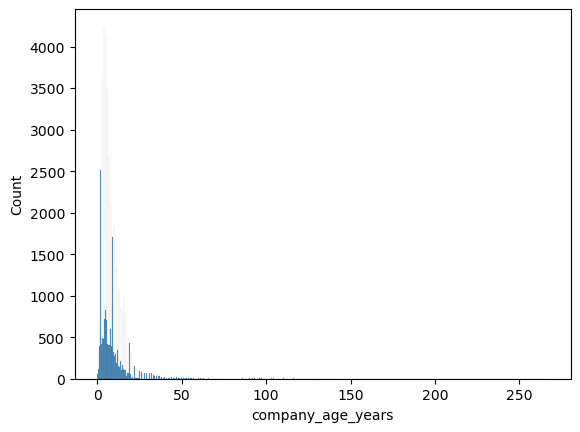

In [120]:
sns.histplot(df['company_age_years'])

In [121]:
# how many companies are there older than 50 years?
(df['company_age_years'] > 50).sum()

243

In [122]:
# drop these companies
index = df[df['company_age_years'] > 50].index
df.drop(labels=index, inplace=True)

In [123]:
# checking
df['founded_at'].min()

Timestamp('1967-01-01 00:00:00')

[Text(0.5, 1.0, 'Histogram of Company Ages in Years')]

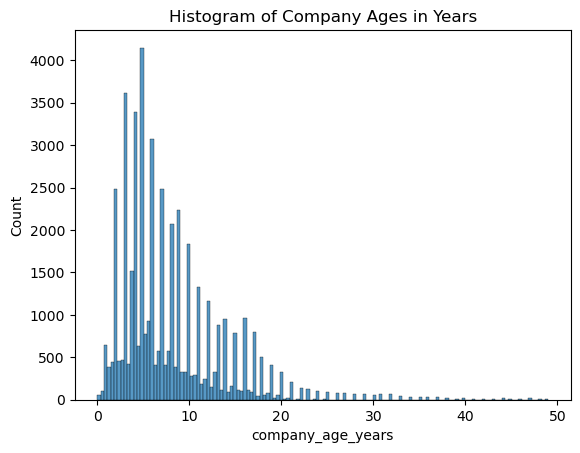

In [124]:
sns.histplot(df['company_age_years']).set(title='Histogram of Company Ages in Years')

[Text(0.5, 1.0, 'Histogram of Total Amounts Raised in Logscale')]

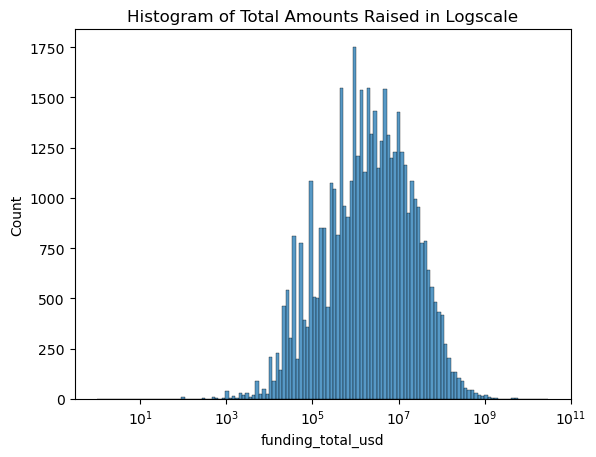

In [125]:
sns.histplot(df['funding_total_usd'], log_scale=True).set(title='Histogram of Total Amounts Raised in Logscale')

<Axes: title={'center': 'Top 10 Countries by Company Count'}, ylabel='country_code'>

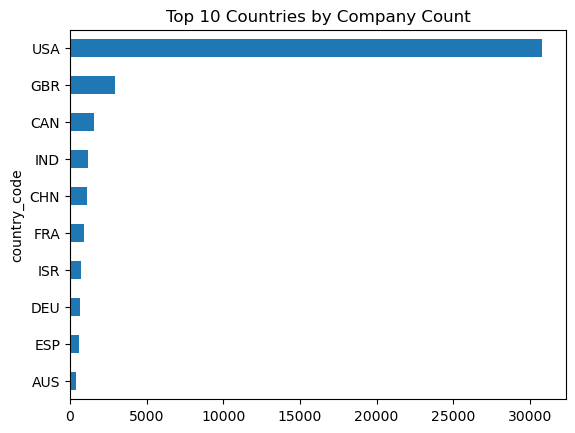

In [126]:
df['country_code'].value_counts()[:10].sort_values(ascending=True).plot(kind='barh', title='Top 10 Countries by Company Count')

In [127]:
df.groupby('status')['funding_total_usd'].mean()

status
acquired     2.822948e+07
closed       1.134754e+07
ipo          1.325684e+08
operating    1.387390e+07
Name: funding_total_usd, dtype: float64

<Axes: ylabel='status'>

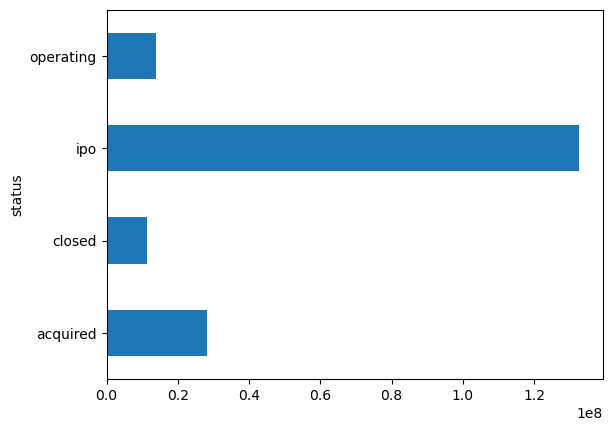

In [128]:
df.groupby('status')['funding_total_usd'].mean().plot(kind='barh')

In [129]:
df.columns

Index(['Name', 'funding_total_usd', 'status', 'country_code', 'city',
       'funding_rounds', 'founded_at', 'first_funding_at', 'last_funding_at',
       'categories', 'Advertising', 'Analytics', 'Apps', 'Big Data',
       'Biotechnology', 'Clean Technology', 'Cloud Computing', 'Consulting',
       'Curated Web', 'E-Commerce', 'Education', 'Enterprise Software',
       'Entertainment', 'Fashion', 'FinTech', 'Finance', 'Financial Services',
       'Games', 'Hardware + Software', 'Health Care', 'Health and Wellness',
       'Hospitality', 'Information Technology', 'Internet', 'Manufacturing',
       'Marketplaces', 'Media', 'Medical', 'Messaging', 'Mobile', 'Music',
       'Networking', 'News', 'Real Estate', 'Retail', 'SaaS',
       'Sales and Marketing', 'Search', 'Security', 'Semiconductors',
       'Services', 'Social Media', 'Social Network Media', 'Software',
       'Sports', 'Startups', 'Technology', 'Travel', 'Video', 'Web Hosting',
       'Other', 'company_age_days', 'company_a

In [130]:
catgroup = df.groupby('successful')[['Advertising', 'Analytics', 'Apps',
       'Big Data', 'Biotechnology', 'Clean Technology', 'Cloud Computing',
       'Consulting', 'Curated Web', 'E-Commerce', 'Education',
       'Enterprise Software', 'Entertainment', 'Fashion', 'FinTech', 'Finance',
       'Financial Services', 'Games', 'Hardware + Software', 'Health Care',
       'Health and Wellness', 'Hospitality', 'Information Technology',
       'Internet', 'Manufacturing', 'Marketplaces', 'Media', 'Medical',
       'Messaging', 'Mobile', 'Music', 'Networking', 'News', 'Real Estate',
       'Retail', 'SaaS', 'Sales and Marketing', 'Search', 'Security',
       'Semiconductors', 'Services', 'Social Media', 'Social Network Media',
       'Software', 'Sports', 'Startups', 'Technology', 'Travel', 'Video',
       'Web Hosting', 'Other']].sum().T#.plot(kind='barh', stacked=True)

In [131]:
catgroup['Total'] = catgroup[0] + catgroup[1]

<Axes: title={'center': 'Success vs. Failure for Top 10 Listed Categories'}>

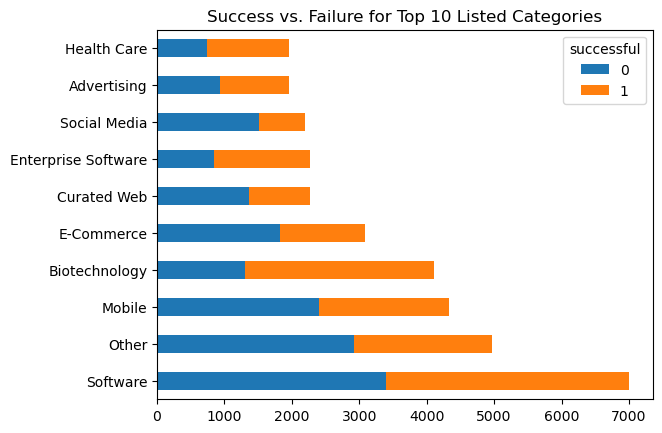

In [132]:
catgroup.sort_values('Total', ascending=False)[:10].drop(columns='Total').plot(kind='barh', stacked=True, title='Success vs. Failure for Top 10 Listed Categories')

In [133]:
temp = df.loc[df['city'].isin(list(df['city'].value_counts()[:14].index))]

<Axes: title={'center': 'Statuses for 14 Most Common Cities'}, ylabel='city'>

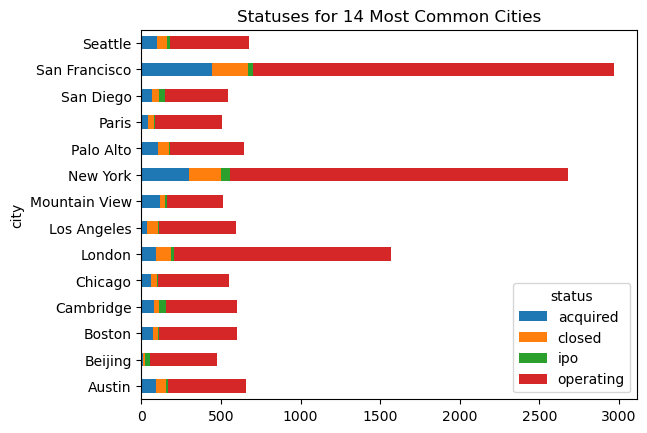

In [134]:
temp.groupby(['status', 'city'])['city'].count().unstack().T.plot(kind='barh', stacked=True, title='Statuses for 14 Most Common Cities')

In [135]:
# now that I've one hot encoded the categorical columns I can remove the originals
df.drop(columns=['categories', 'founded_at', 'first_funding_at', 'last_funding_at', 'country_code', 'city', 'status', 'funding_total_usd'], inplace=True)

In [136]:
df.head()

,Name,funding_rounds,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,successful
0,#fame,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1619,4.44,1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,:Qounter,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.71,-96,284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0-6.com,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.98,443,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,01Games Technology,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2098,5.75,1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ondine Biomedical Inc.,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.99,4695,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [137]:
# check for multicollinearity
corrDf = df.drop(columns=['successful', 'Name']).corr()
mask = np.triu(corrDf)

<Axes: >

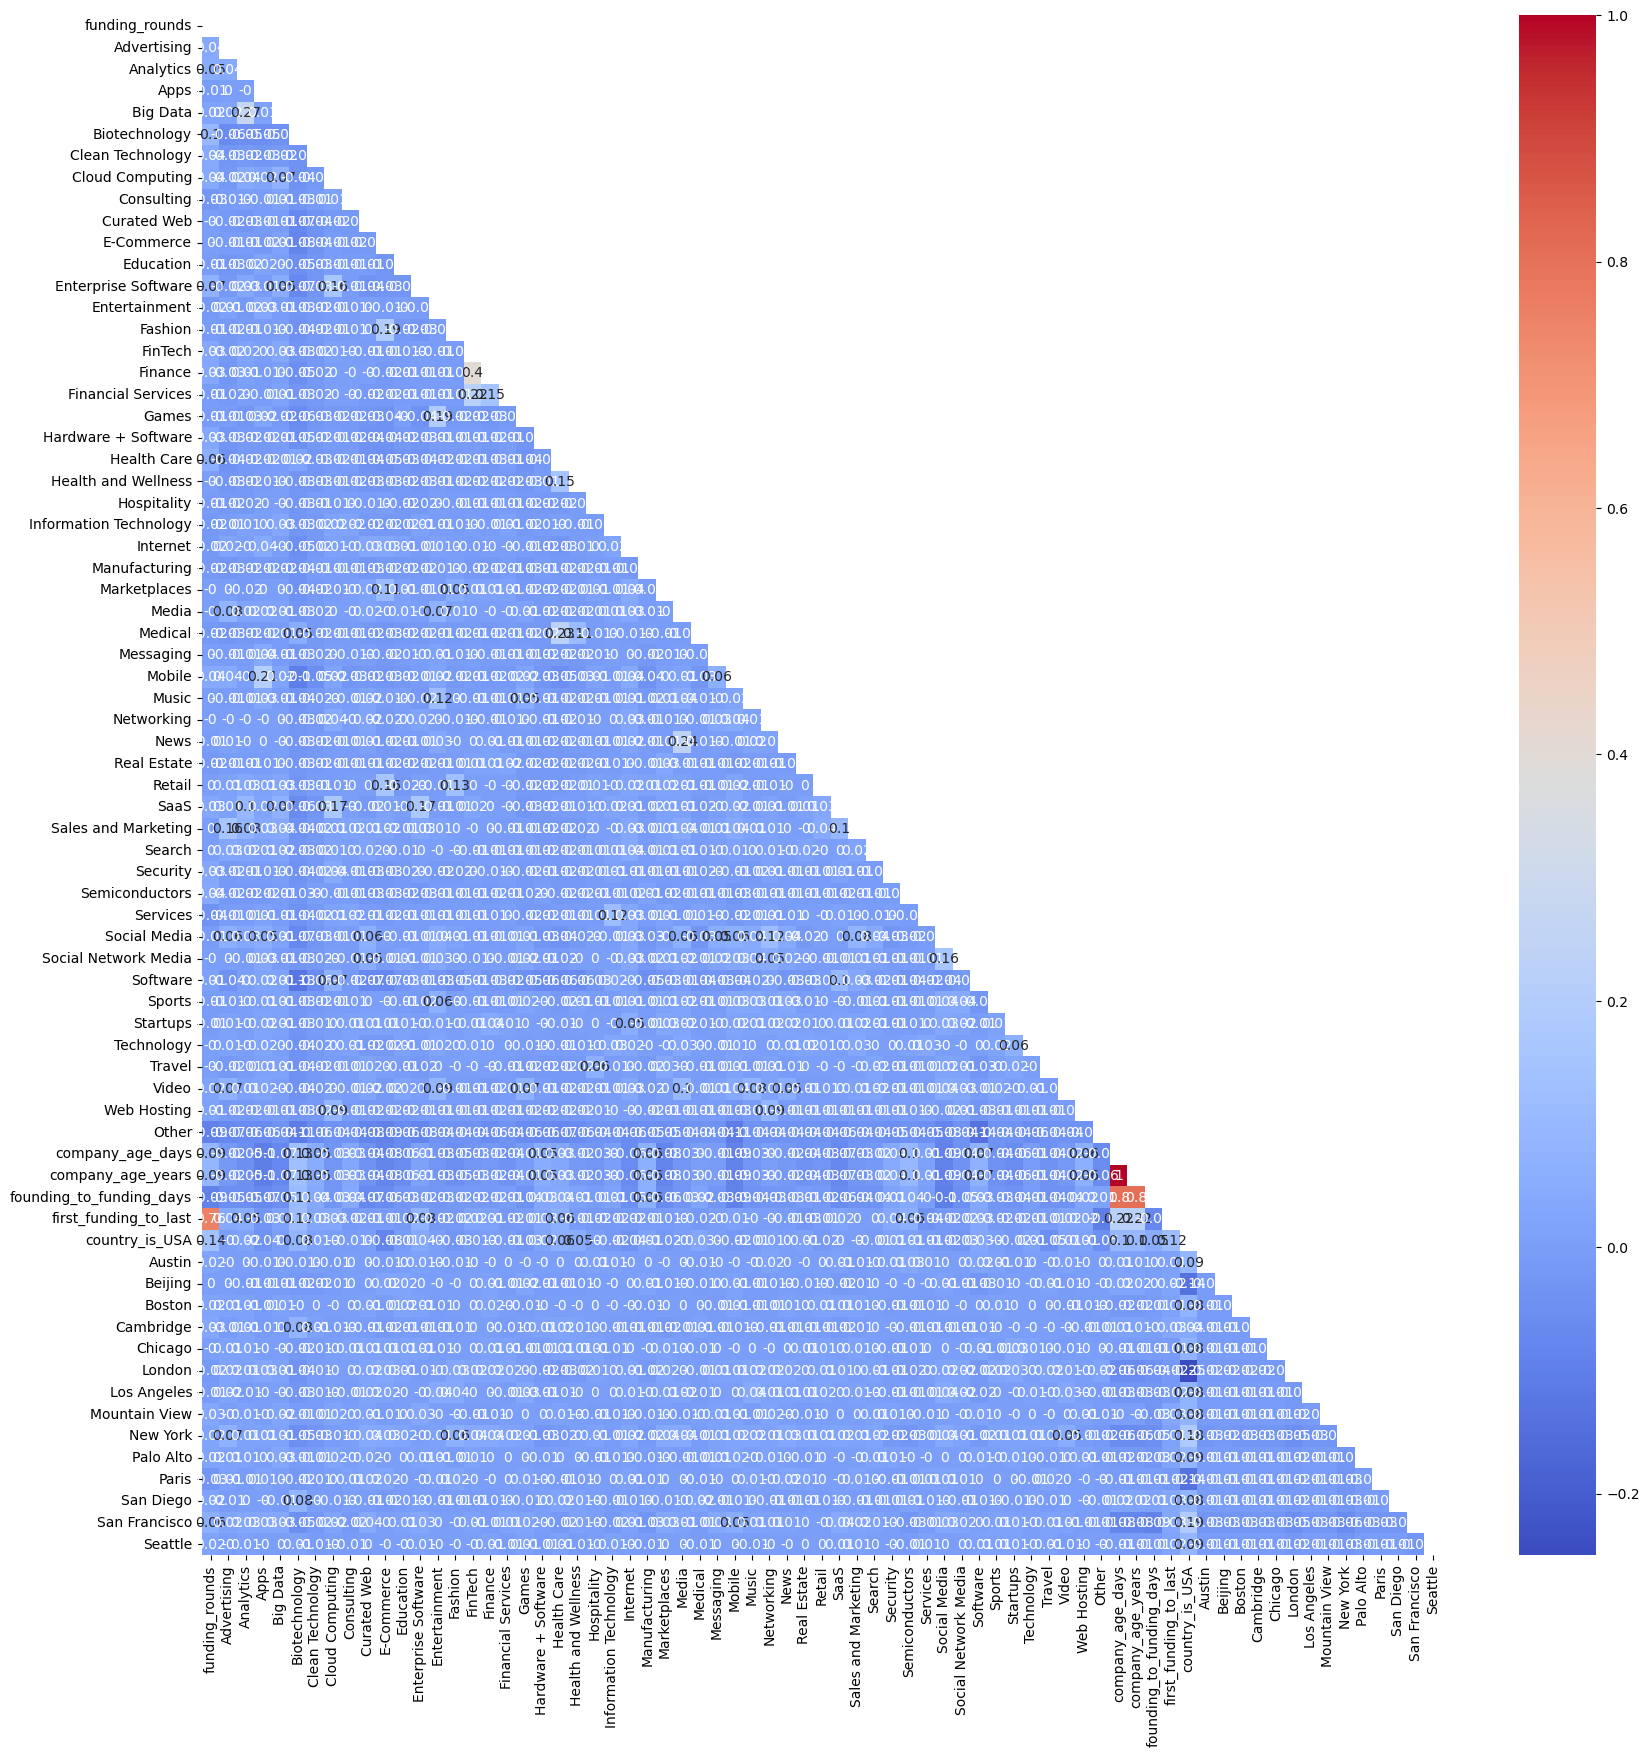

In [138]:
plt.figure(figsize=(20,20))
sns.heatmap(corrDf.round(2), annot=True, mask=mask, cmap='coolwarm')

In [139]:
np.corrcoef(df['company_age_days'], df['company_age_years'])

array([[1.        , 0.99999989],
       [0.99999989, 1.        ]])

In [140]:
np.corrcoef(df['company_age_years'], df['founding_to_funding_days'])

array([[1.       , 0.8023237],
       [0.8023237, 1.       ]])

In [141]:
np.corrcoef(df['Finance'], df['FinTech'])

array([[1.        , 0.40348534],
       [0.40348534, 1.        ]])

In [142]:
np.corrcoef(df['first_funding_to_last'], df['funding_rounds'])

array([[1.       , 0.7557665],
       [0.7557665, 1.       ]])

In [143]:
# drop problematic columns
df.drop(columns=['first_funding_to_last', 'founding_to_funding_days', 'company_age_days'], inplace=True)

In [144]:
# make a single column for finance related companies
df['Anything_Finance'] = np.where((df['FinTech'] == 1) | (df['Finance'] == 1) | (df['Financial Services'] == 1), 1, 0)

In [145]:
# drop the original finance columns
df.drop(columns=['FinTech', 'Finance', 'Financial Services'], inplace=True)

In [146]:
df.head()

,Name,funding_rounds,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_years,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,successful,Anything_Finance
0,#fame,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,:Qounter,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0-6.com,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.98,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,01Games Technology,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ondine Biomedical Inc.,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [147]:
# check for multicollinearity again
corrDf = df.drop(columns=['successful', 'Name']).corr()
mask = np.triu(corrDf)

<Axes: >

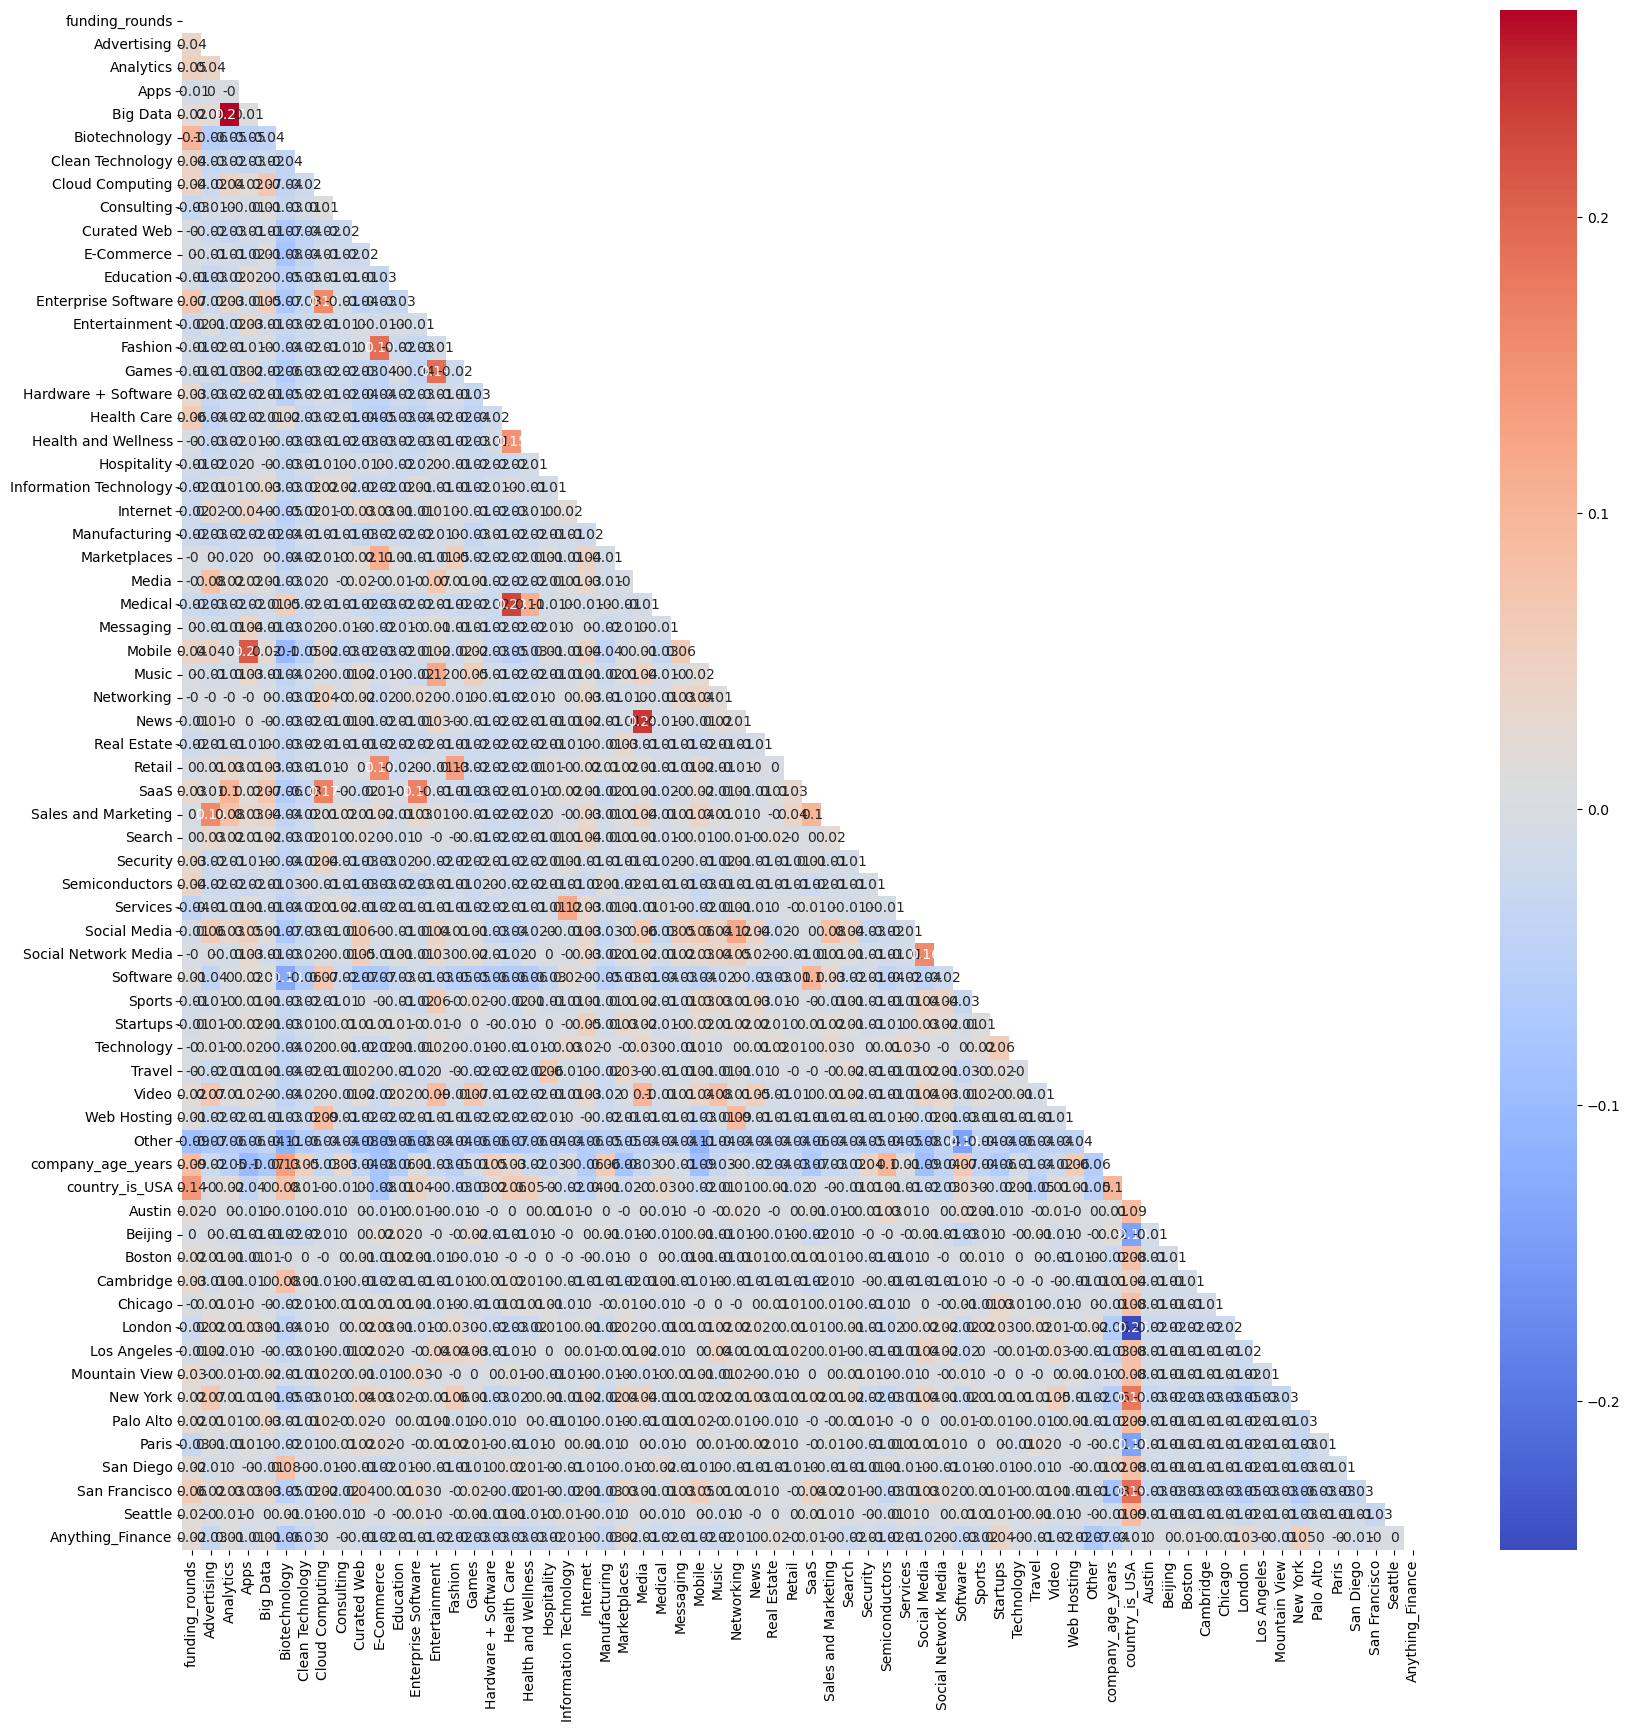

In [148]:
plt.figure(figsize=(20,20))
sns.heatmap(corrDf.round(2), annot=True, mask=mask, cmap='coolwarm')

# Modelling <a class="anchor" id="modelling"></a>

I'll manually split my train and test sets so that the models will train on companies older than 3.8 years and will be tested on newer companies. This cutoff means that there will be around 20% of the data in the test set.

In [149]:
testdf = df[df['company_age_years'] <= 3.8]

In [150]:
traindf = df[df['company_age_years'] > 3.8]

In [153]:
X_train = traindf.drop(columns=['successful', 'Name'])
y_train = traindf['successful']
X_test = testdf.drop(columns=['successful', 'Name'])
y_test = testdf['successful']

## Logistic Regression Model <a class="anchor" id="logregmodel"></a>

In [154]:
# instantiate a logistic regression model
logreg_model = LogisticRegression(max_iter=10000)

# fit it to training data
logreg_model.fit(X_train, y_train)

# score the accuracy of the model
lr_train_score = logreg_model.score(X_train, y_train)
lr_test_score = logreg_model.score(X_test, y_test)

print(f"Score on training set: {lr_train_score}")
print(f"Score on test set: {lr_test_score}")

Score on training set: 0.715635942395282
Score on test set: 0.7684086779950839


In [155]:
# Generate confusion matrix
lr_pred = logreg_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, lr_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Failure", "Predicted Success"],
    index=["True Failure", "True Success"]
)

display(cf_df)

,Predicted Failure,Predicted Success
True Failure,6497,633
True Success,1534,693


In [156]:
precision = precision_score(y_test, lr_pred)
recall = recall_score(y_test, lr_pred)
f1 = f1_score(y_test, lr_pred)
print(f'precision = {precision}, recall = {recall}, f1 = {f1}')

precision = 0.5226244343891403, recall = 0.3111809609339919, f1 = 0.39009287925696595


In [157]:
# creating a dataframe of the coefficients
coef = pd.DataFrame(logreg_model.coef_,  columns = X_train.columns)

In [158]:
coef

,funding_rounds,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_years,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,Anything_Finance
0,0.687978,0.135645,0.282018,-0.27664,0.20121,0.428251,0.459215,0.043316,-0.319695,-0.345215,-0.139985,-0.337889,0.404817,0.053862,0.068704,-0.14824,0.024792,0.371313,-0.033064,-0.158529,0.296125,-0.077813,0.110672,-0.380194,0.129003,0.059279,-0.285298,0.01404,-0.557745,0.012355,-0.033612,0.035939,0.04194,-0.206773,-0.007417,-0.307574,0.349465,0.719192,-0.105002,-0.503824,-0.4825,-0.034401,-0.347828,-0.206475,0.199881,-0.069806,0.047108,0.414173,0.089094,0.112409,0.035724,0.140091,1.401874,0.446038,0.600982,0.210659,0.100544,0.041782,0.741418,0.338891,0.544291,0.415526,0.309105,0.62819,0.206703,0.284425


In [159]:
# adding the odds ratios to the dataframe to look at them side by side with the coefficients
coef.loc[1] = np.exp(logreg_model.coef_)[0]
coef.rename({0:'coefficients', 1:'odds_ratios'}, inplace=True)

In [160]:
# sorting by coefficients, descending --> positively correlates with success
coef.sort_values(axis=1, by='coefficients', ascending=False)

,Beijing,Mountain View,Semiconductors,funding_rounds,San Francisco,Cambridge,Palo Alto,Clean Technology,Boston,Biotechnology,Paris,Web Hosting,Enterprise Software,Health Care,Security,New York,San Diego,Information Technology,Anything_Finance,Analytics,Chicago,Seattle,Big Data,Technology,Austin,Advertising,Media,company_age_years,Manufacturing,London,Other,Fashion,Medical,Entertainment,Video,Cloud Computing,Retail,Los Angeles,Real Estate,country_is_USA,Hardware + Software,Mobile,Networking,Sales and Marketing,Health and Wellness,News,Software,Travel,Internet,Services,E-Commerce,Games,Hospitality,Startups,SaaS,Apps,Messaging,Search,Consulting,Education,Curated Web,Sports,Marketplaces,Social Network Media,Social Media,Music
coefficients,1.401874,0.741418,0.719192,0.687978,0.628190,0.600982,0.544291,0.459215,0.446038,0.428251,0.415526,0.414173,0.404817,0.371313,0.349465,0.338891,0.309105,0.296125,0.284425,0.282018,0.210659,0.206703,0.201210,0.199881,0.140091,0.135645,0.129003,0.112409,0.110672,0.100544,0.089094,0.068704,0.059279,0.053862,0.047108,0.043316,0.041940,0.041782,0.035939,0.035724,0.024792,0.014040,0.012355,-0.007417,-0.033064,-0.033612,-0.034401,-0.069806,-0.077813,-0.105002,-0.139985,-0.148240,-0.158529,-0.206475,-0.206773,-0.276640,-0.285298,-0.307574,-0.319695,-0.337889,-0.345215,-0.347828,-0.380194,-0.482500,-0.503824,-0.557745
odds_ratios,4.062805,2.098909,2.052775,1.989688,1.874215,1.823909,1.723385,1.582832,1.562110,1.534571,1.515168,1.513119,1.499028,1.449636,1.418308,1.403390,1.362205,1.344638,1.328998,1.325803,1.234492,1.229618,1.222881,1.221257,1.150378,1.145275,1.137694,1.118970,1.117028,1.105772,1.093184,1.071119,1.061071,1.055339,1.048235,1.044267,1.042832,1.042668,1.036592,1.036370,1.025102,1.014139,1.012432,0.992611,0.967476,0.966947,0.966184,0.932575,0.925137,0.900322,0.869371,0.862224,0.853398,0.813446,0.813204,0.758327,0.751790,0.735228,0.726370,0.713275,0.708068,0.706221,0.683729,0.617238,0.604216,0.572499


In [161]:
# sorting by coefficients, ascending --> negatively correlates with success
coef.sort_values(axis=1, by='coefficients')

,Music,Social Media,Social Network Media,Marketplaces,Sports,Curated Web,Education,Consulting,Search,Messaging,Apps,SaaS,Startups,Hospitality,Games,E-Commerce,Services,Internet,Travel,Software,News,Health and Wellness,Sales and Marketing,Networking,Mobile,Hardware + Software,country_is_USA,Real Estate,Los Angeles,Retail,Cloud Computing,Video,Entertainment,Medical,Fashion,Other,London,Manufacturing,company_age_years,Media,Advertising,Austin,Technology,Big Data,Seattle,Chicago,Analytics,Anything_Finance,Information Technology,San Diego,New York,Security,Health Care,Enterprise Software,Web Hosting,Paris,Biotechnology,Boston,Clean Technology,Palo Alto,Cambridge,San Francisco,funding_rounds,Semiconductors,Mountain View,Beijing
coefficients,-0.557745,-0.503824,-0.482500,-0.380194,-0.347828,-0.345215,-0.337889,-0.319695,-0.307574,-0.285298,-0.276640,-0.206773,-0.206475,-0.158529,-0.148240,-0.139985,-0.105002,-0.077813,-0.069806,-0.034401,-0.033612,-0.033064,-0.007417,0.012355,0.014040,0.024792,0.035724,0.035939,0.041782,0.041940,0.043316,0.047108,0.053862,0.059279,0.068704,0.089094,0.100544,0.110672,0.112409,0.129003,0.135645,0.140091,0.199881,0.201210,0.206703,0.210659,0.282018,0.284425,0.296125,0.309105,0.338891,0.349465,0.371313,0.404817,0.414173,0.415526,0.428251,0.446038,0.459215,0.544291,0.600982,0.628190,0.687978,0.719192,0.741418,1.401874
odds_ratios,0.572499,0.604216,0.617238,0.683729,0.706221,0.708068,0.713275,0.726370,0.735228,0.751790,0.758327,0.813204,0.813446,0.853398,0.862224,0.869371,0.900322,0.925137,0.932575,0.966184,0.966947,0.967476,0.992611,1.012432,1.014139,1.025102,1.036370,1.036592,1.042668,1.042832,1.044267,1.048235,1.055339,1.061071,1.071119,1.093184,1.105772,1.117028,1.118970,1.137694,1.145275,1.150378,1.221257,1.222881,1.229618,1.234492,1.325803,1.328998,1.344638,1.362205,1.403390,1.418308,1.449636,1.499028,1.513119,1.515168,1.534571,1.562110,1.582832,1.723385,1.823909,1.874215,1.989688,2.052775,2.098909,4.062805


## Decision Tree Model <a class="anchor" id="dtmodel"></a>

In [ ]:
# instantiate decision tree
dt_model = DecisionTreeClassifier(max_depth=7)

# fit it to training data
dt_model.fit(X_train, y_train)

# score the accuracy
dt_train_score = dt_model.score(X_train, y_train)
dt_test_score = dt_model.score(X_test, y_test)

print(f"Score on training set: {dt_train_score}")
print(f"Score on test set: {dt_test_score}")

In [ ]:
# without going in-depth into hyperparameter optimization, I can see that this tree model is more accurate than the logistic regression by about 1%

## Random Forest Model <a class="anchor" id="rfmodel"></a>

In [ ]:
# instantiate
rf_model = RandomForestClassifier(n_estimators=50, max_depth=9)

# fit
rf_model.fit(X_train, y_train)

# score
rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)

print(f"Score on training set: {rf_train_score}")
print(f"Score on test set: {rf_test_score}")

In [ ]:
# no better than decision tree 

## Support Vector Machine Model <a class="anchor" id="svmmodel"></a>

In [ ]:
# instantiate
svm_model = LinearSVC(dual='auto')

# fit
svm_model.fit(X_train, y_train)

# score
svm_train_score = svm_model.score(X_train, y_train)
svm_test_score = svm_model.score(X_test, y_test)

print(f"Score on training set: {svm_train_score}")
print(f"Score on test set: {svm_test_score}")

In [ ]:
# instantiate
svc_model = SVC()

# fit
svc_model.fit(X_train, y_train)

# score
svc_train_score = svc_model.score(X_train, y_train)
svc_test_score = svc_model.score(X_test, y_test)

print(f"Score on training set: {svc_train_score}")
print(f"Score on test set: {svc_test_score}")

In [ ]:
# go through model evaluation notebook, plot ROC curves

## GridSearch

## Neural Network <a class="anchor" id="nnmodel"></a>

In [ ]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2)) # Set 20% of the nodes to 0.
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    verbose=1,
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_test, y_test))

In [ ]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(67, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(30, activation="relu"))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(7, activation="relu"))
model.add(layers.Dense(5, activation="relu"))
model.add(layers.Dense(3, activation="relu"))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    verbose=1,
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_test, y_test))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Analysis With Descriptions <a class="anchor" id="descriptions"></a>

In [4]:
# loading in the description data
desc = pd.read_csv('Data/descriptions.csv')

In [5]:
# surveying
desc.head()

,name,city,tagline,description
0,Campus Bubble,Atlanta,Your Academic Identity,Campus Bubble (“CB”) is the Academic Community...
1,DueProps,Atlanta,Gamifying the $46 Billion Employee Incentives ...,t unprecedented ...
2,SalesLoft,Atlanta,Quickly build high-quality prospect lists,build high-quality prospect lists\n
3,The Coca-Cola Company,Atlanta,NaN,Coca-Cola Journey is a digital magazine that f...
4,EarthLink,Atlanta,NaN,NaN


In [164]:
desc.isna().sum()

name              4
city              0
tagline        5308
description    4864
dtype: int64

In [165]:
desc.shape

(42038, 4)

I need to get unformatted versions for all names in both data sets so that the join can get the most possible matches. To do this I will strip the name columns of all spaces or extra characters and make them lower case.

In [166]:
# instantiating unformatted name column in description dataset
desc['name_unformatted'] = desc['name']

In [175]:
for i in range(len(desc['name_unformatted'])):
    desc['name_unformatted'][i] = str(desc['name_unformatted'][i]).lower().replace(' ', '') # makes everything lowercase and removes spaces
    if not desc['name_unformatted'][i].isalnum():
        for char in desc['name_unformatted'][i]:
            if not char.isalnum():
                desc['name_unformatted'][i] = desc['name_unformatted'][i].replace(char, '') # removes non-alphanumeric characters

In [177]:
desc.tail() # looks good

,name,city,tagline,description,name_unformatted
42033,Venture Philanthrophy Partners,Washington DC,NaN,NaN,venturephilanthrophypartners
42034,The Shopping Asylum,Washington DC,Online QVC For Millennial,NaN,theshoppingasylum
42035,UP Technologies,Washington DC,Ultra Portable Commercial Hardware Solutions,Ultra Portable Technologies (UP Technologies) ...,uptechnologies
42036,Galaxie restaurant and bar,Washington DC,"concept of a unique, modern restaurant",Concept of a modern 10 -15 000 sf restaurant w...,galaxierestaurantandbar
42037,Avenger Mobile,Washington DC,Avenger Mobile aims to create apps that solve ...,Mobile aims to create apps that solve real-wo...,avengermobile


In [184]:
# now do the same for the original dataframe
df['name_unformatted'] = df['Name']

In [185]:
df.head()

,Name,funding_rounds,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_years,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,successful,Anything_Finance,name_unformatted
0,#fame,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,#fame
1,:Qounter,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,:Qounter
2,0-6.com,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.98,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0-6.com
3,01Games Technology,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01Games Technology
4,Ondine Biomedical Inc.,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ondine Biomedical Inc.


In [186]:
df.reset_index(drop=True, inplace=True)

In [187]:
for i in range(len(df['name_unformatted'])):
    df.at[i, 'name_unformatted'] = str(df['name_unformatted'][i]).lower().replace(' ', '') # makes everything lowercase and removes spaces
    if not df['name_unformatted'][i].isalnum():
        for char in df['name_unformatted'][i]:
            if not char.isalnum():
                df.at[i, 'name_unformatted'] = df['name_unformatted'][i].replace(char, '') # removes non-alphanumeric characters

In [188]:
df.tail() # looks good

,Name,funding_rounds,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_years,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,successful,Anything_Finance,name_unformatted
47335,Zytoprotec,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,zytoprotec
47336,Zzish,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.90,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,zzish
47337,ZZNode Science and Technology,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.76,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,zznodescienceandtechnology
47338,Zzzzapp Wireless ltd.,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,zzzzappwirelessltd
47339,Ôasys,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.98,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,ôasys


In [189]:
# joining these two dataframes on the unformatted name columns
startups = desc.join(df.set_index('name_unformatted'), on='name_unformatted', how='inner', lsuffix='_description', rsuffix='_nodescription')

In [190]:
startups.head()

,name,city,tagline,description,name_unformatted,Name,funding_rounds,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_years,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,successful,Anything_Finance
1,DueProps,Atlanta,Gamifying the $46 Billion Employee Incentives ...,t unprecedented ...,dueprops,DueProps,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,SalesLoft,Atlanta,Quickly build high-quality prospect lists,build high-quality prospect lists\n,salesloft,SalesLoft,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4.95,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,EarthLink,Atlanta,NaN,NaN,earthlink,EarthLink,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,21.99,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,REscour,Atlanta,Market intelligence and analytics for commerci...,REscour is a data platform and decision engine...,rescour,REscour,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.98,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,Kabbage,Atlanta,NaN,Kabbage delivers small businesses financing. B...,kabbage,Kabbage,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.06,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [191]:
startups.shape

(8613, 73)

In [192]:
startups.isna().sum()

name                   0
city                   0
tagline             2113
description         1819
name_unformatted       0
                    ... 
San Diego              0
San Francisco          0
Seattle                0
successful             0
Anything_Finance       0
Length: 73, dtype: int64

In [193]:
startups.dropna(subset='description', inplace=True)

In [194]:
startups.reset_index(drop=True, inplace=True)

In [195]:
startups.shape

(6794, 73)

In [197]:
startups.drop(columns='tagline', inplace=True)

In [200]:
startups.isna().sum()

name                0
city                0
description         0
name_unformatted    0
Name                0
                   ..
San Diego           0
San Francisco       0
Seattle             0
successful          0
Anything_Finance    0
Length: 72, dtype: int64

In [201]:
startups['description_length'] = startups['description'].apply(len)

In [202]:
startups.head()

,name,city,description,name_unformatted,Name,funding_rounds,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_years,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,successful,Anything_Finance,description_length
0,DueProps,Atlanta,t unprecedented ...,dueprops,DueProps,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19
1,SalesLoft,Atlanta,build high-quality prospect lists\n,salesloft,SalesLoft,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4.95,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35
2,REscour,Atlanta,REscour is a data platform and decision engine...,rescour,REscour,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.98,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,270
3,Kabbage,Atlanta,Kabbage delivers small businesses financing. B...,kabbage,Kabbage,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.06,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,140
4,OpenStudy,Atlanta,rovides real-time study communities for over 4...,openstudy,OpenStudy,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.95,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117


In [225]:
startups['description'][4]

'rovides real-time study communities for over 40 OpenCourseWare and OER providers, marrying open content with open ...'

## Word Embeddings

In [ ]:
# hist of length of descrps